# Student Grade Exploratory Data Analysis Project

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('student-dataset.csv')
df.drop(columns=['latitude', 'longitude', 'portfolio.rating', 'coverletter.rating', 'refletter.rating', 'ethnic.group'], inplace=True)
df.drop(df.columns[0], axis=1).describe()

,age,english.grade,math.grade,sciences.grade,language.grade
count,307.000000,307.000000,307.000000,307.000000,307.000000
mean,21.964169,3.369707,3.414332,3.446580,4.396417
std,1.248013,0.538724,0.476839,0.509081,0.996474
min,19.000000,1.500000,2.100000,1.400000,1.000000
25%,21.000000,3.100000,3.100000,3.200000,4.000000
50%,22.000000,3.500000,3.500000,3.600000,5.000000
75%,23.000000,3.800000,3.800000,3.800000,5.000000
max,26.000000,4.000000,4.000000,4.000000,5.000000


There is a significantly larger standard deviation in the Language grade, indicating that students perform inconsitently as a whole.

Students are achieving the highest grades in their Language classes, followed by Science, then lastly Math and English.

In [118]:
df.head(3)

,id,name,nationality,city,gender,age,english.grade,math.grade,sciences.grade,language.grade
0,0,Kiana Lor,China,Suzhou,F,22,3.5,3.7,3.1,1.0
1,1,Joshua Lonaker,United States of America,Santa Clarita,M,22,2.9,3.2,3.6,5.0
2,2,Dakota Blanco,United States of America,Oakland,F,22,3.9,3.8,3.2,5.0


We are provided information on student nationality, gender, and age which will be useful when making predictions based on demographics.

## What are the top-performing nationalities for each subject?

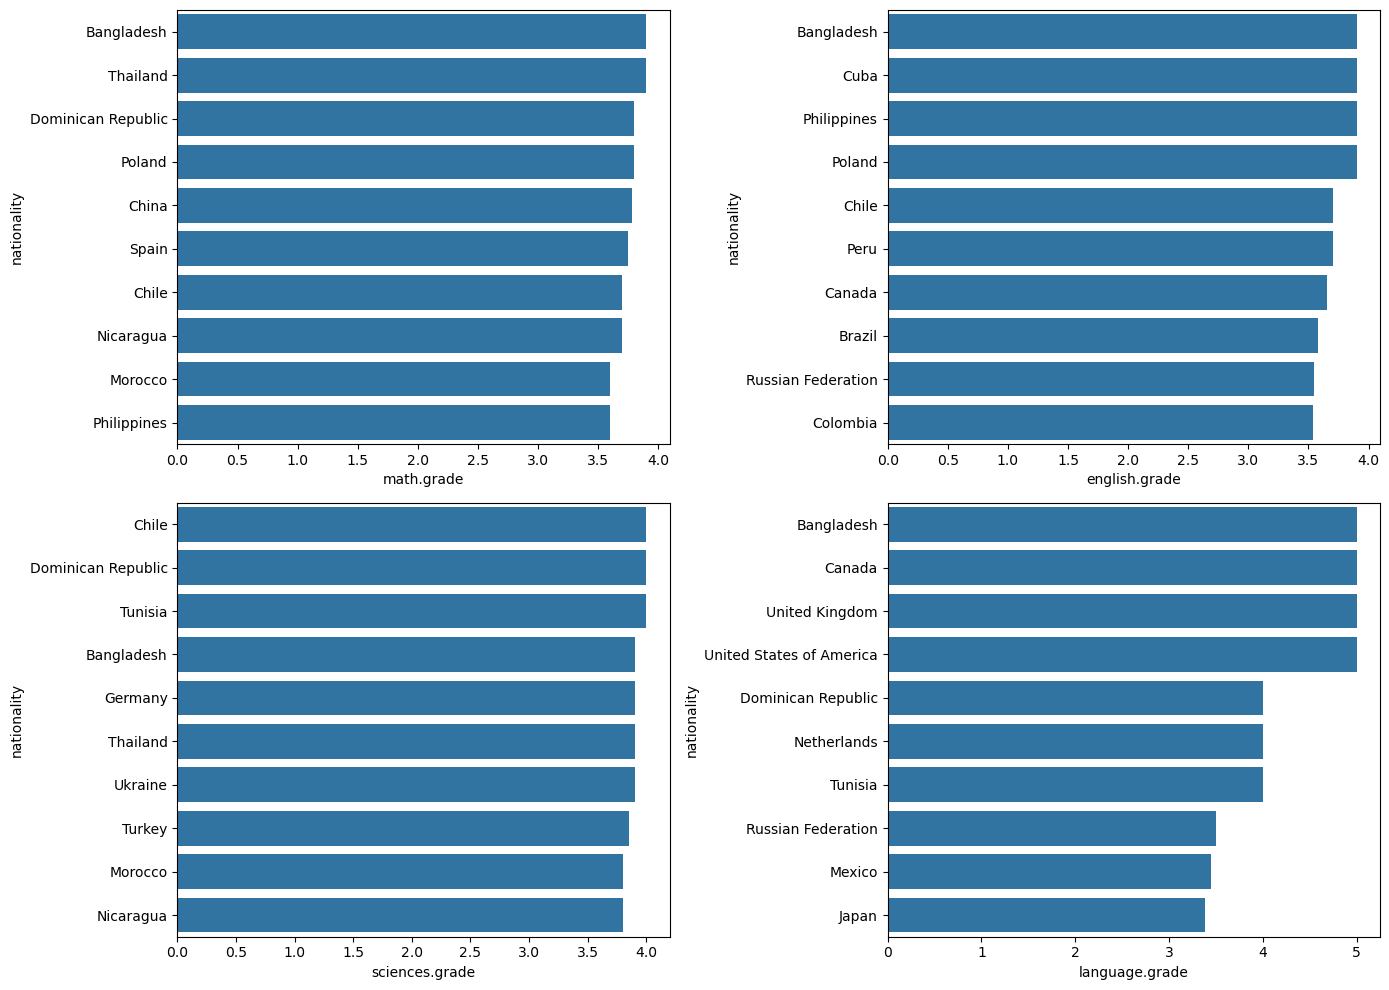

In [119]:
subjects = ['math.grade', 'english.grade', 'sciences.grade', 'language.grade']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid
for i, subject in enumerate(subjects):
    ax = axes[i // 2, i % 2]
    top_10 = df.groupby('nationality')[subject].mean().nlargest(10).reset_index()
    sns.barplot(data=top_10, x=subject, y='nationality', ax=ax)
    plt.tight_layout()

People from Bangladesh were consistently the highest achievers in all subjects besides sciences.

## Which gender stacks up to having better grades for each subject?

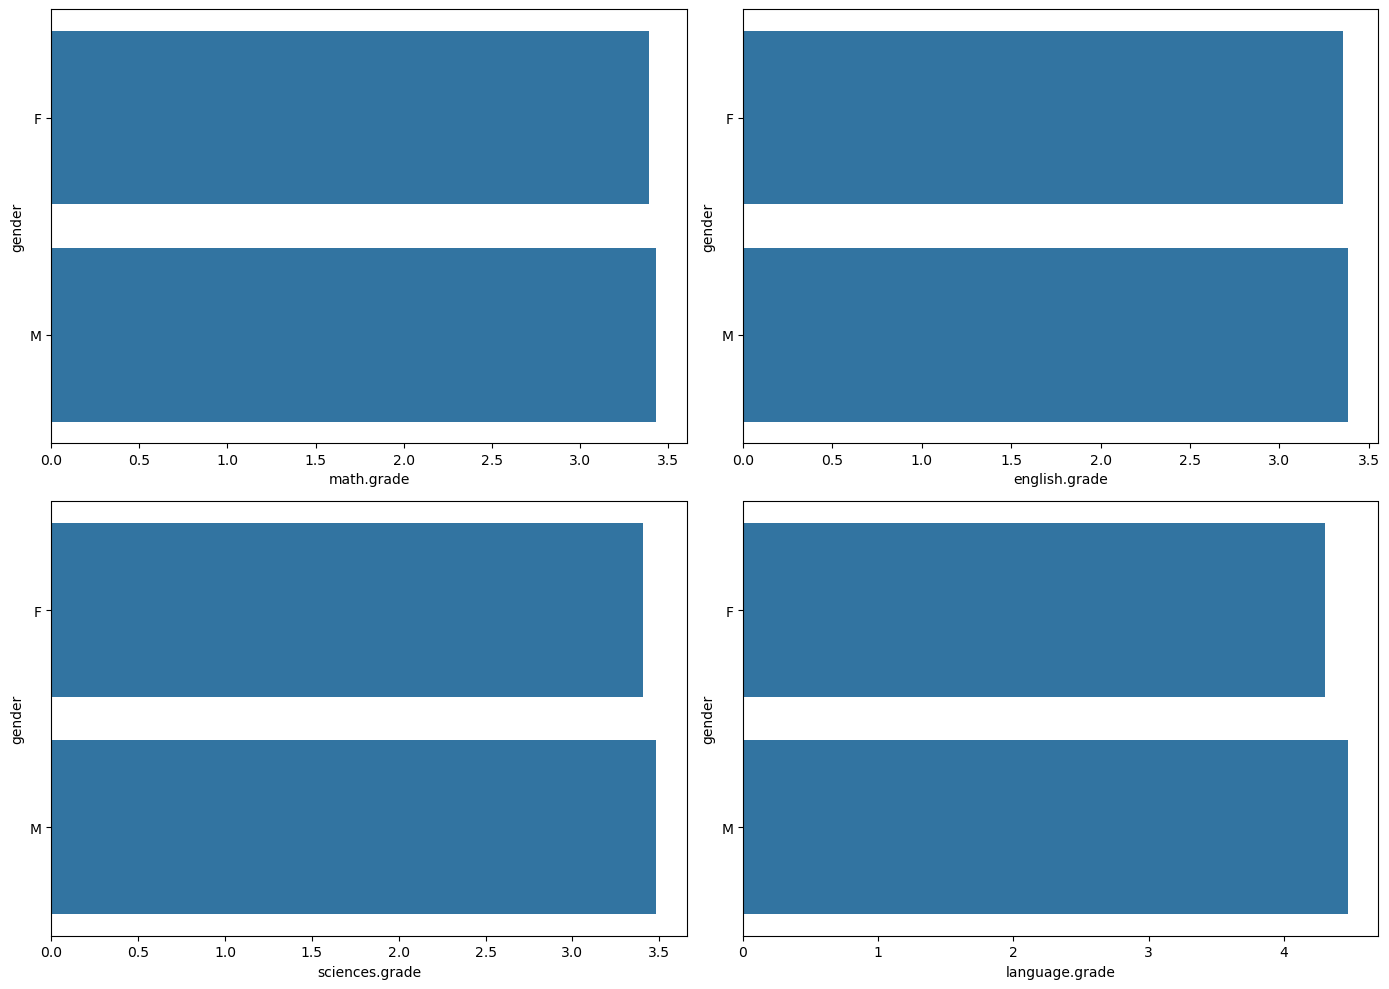

In [120]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
for i, subject in enumerate(subjects):
    ax = axes[i // 2, i % 2]
    filtered_df = df.query('gender != "other"')
    genders = filtered_df.groupby('gender')[subject].mean().reset_index()
    sns.barplot(data=genders, x=subject, y='gender', ax=ax)
    plt.tight_layout()

Interestingly, males outperformed females in all subjects.

## What are the cities with the worst language grades?
Since there is a considerably large standard deviation for this particular subject...

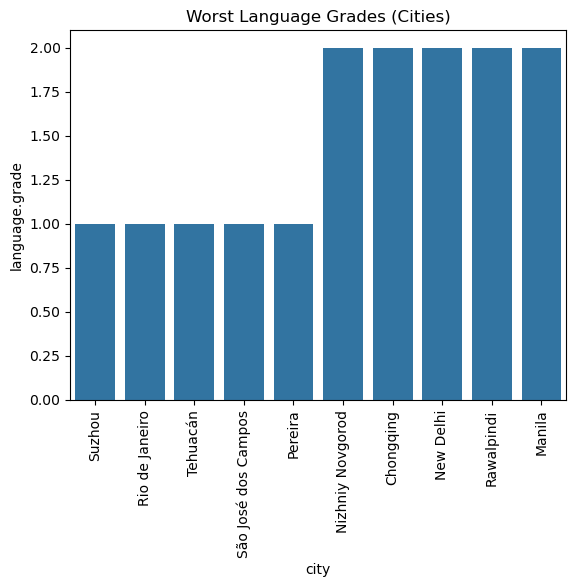

In [130]:
language_grades_city = df.groupby('city')['language.grade'].mean().reset_index().sort_values(by='language.grade', ascending = True).head(10)
ax = sns.barplot(x='city', y='language.grade',data = language_grades_city)
plt.title('Worst Language Grades (Cities)')
plt.xticks(rotation=90)
plt.show()

Asian and South American cities appear to be underperforming in languages. 